# Data Collection

## With Leak

In [10]:
import serial
import numpy as np
import os
import time
import csv

# Configuration des paramètres
SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200
NUM_SAMPLES = 1024
SAMPLE_RATE = 88200
MAX_DISPLAY_FREQ = 22000
DURATION = 10  # Durée d'enregistrement
SAVE_DIR = "collected_data"
FILENAME = "spectrogram_data_leak.csv"

os.makedirs(SAVE_DIR, exist_ok=True)
filepath = os.path.join(SAVE_DIR, FILENAME)

ser = serial.Serial(SERIAL_PORT, BAUD_RATE)
print(f"Collecting data for {DURATION} seconds...")

start_time = time.time()
with open(filepath, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["fft_value_" + str(i) for i in range(NUM_SAMPLES // 2)])

    try:
        while time.time() - start_time < DURATION:
            if ser.in_waiting:
                try:
                    data = ser.readline().decode().strip()
                    fft_data = [float(x) for x in data.split(",") if x]
                    if len(fft_data) == NUM_SAMPLES // 2:
                        writer.writerow(fft_data)
                    else:
                        print(f"Unexpected FFT data length: {len(fft_data)}")
                except Exception as e:
                    print(f"Error reading data: {e}")
    finally:
        ser.close()
        print(f"Data saved to {filepath}")


Error reading data: could not convert string to float: '19.223.64'
Data saved to collected_data/spectrogram_data_leak.csv


## Without Leak

In [9]:
import serial
import numpy as np
import os
import time
import csv

# Configuration des paramètres
SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200
NUM_SAMPLES = 1024
SAMPLE_RATE = 88200
MAX_DISPLAY_FREQ = 22000
DURATION = 10  # Durée d'enregistrement
SAVE_DIR = "collected_data"
FILENAME = "spectrogram_data_no_leak.csv"

os.makedirs(SAVE_DIR, exist_ok=True)
filepath = os.path.join(SAVE_DIR, FILENAME)

ser = serial.Serial(SERIAL_PORT, BAUD_RATE)
print(f"Collecting data for {DURATION} seconds...")

start_time = time.time()
with open(filepath, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["fft_value_" + str(i) for i in range(NUM_SAMPLES // 2)])

    try:
        while time.time() - start_time < DURATION:
            if ser.in_waiting:
                try:
                    data = ser.readline().decode().strip()
                    fft_data = [float(x) for x in data.split(",") if x]
                    if len(fft_data) == NUM_SAMPLES // 2:
                        writer.writerow(fft_data)
                    else:
                        print(f"Unexpected FFT data length: {len(fft_data)}")
                except Exception as e:
                    print(f"Error reading data: {e}")
    finally:
        ser.close()
        print(f"Data saved to {filepath}")


Error reading data: could not convert string to float: '27.5.37'
Data saved to collected_data/spectrogram_data_no_leak.csv


# Visualisation

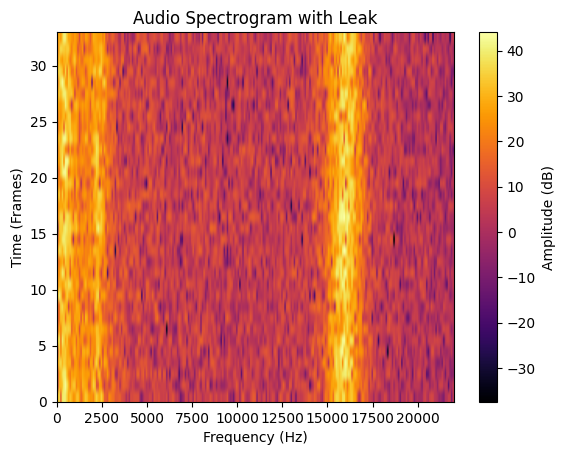

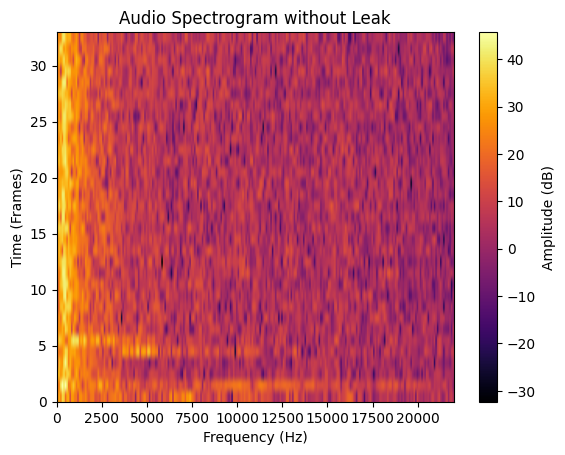

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

SAVE_DIR = "collected_data"
FILENAME_LEAK = "spectrogram_data_leak.csv"
FILENAME_NO_LEAK = "spectrogram_data_no_leak.csv"
NUM_SAMPLES = 1024
SAMPLE_RATE = 88200
MAX_DISPLAY_FREQ = 22000

def load_and_plot_spectrogram(filename, title):
    filepath = os.path.join(SAVE_DIR, filename)
    if not os.path.exists(filepath):
        print(f"Fichier {filepath} introuvable. Assurez-vous d'avoir collecté les données.")
        return

    data = pd.read_csv(filepath).to_numpy()
    time_steps, freq_bins = data.shape
    frequencies = np.linspace(0, SAMPLE_RATE / 2, freq_bins)
    freq_limit_idx = int((MAX_DISPLAY_FREQ / (SAMPLE_RATE / 2)) * freq_bins)
    frequencies = frequencies[:freq_limit_idx]

    spectrogram_data = data[:, :freq_limit_idx]

    fig, ax = plt.subplots()
    cax = ax.imshow(
        spectrogram_data,
        extent=[0, MAX_DISPLAY_FREQ, 0, time_steps],
        aspect="auto",
        cmap="inferno",
        origin="lower",
    )
    fig.colorbar(cax, ax=ax, label="Amplitude (dB)")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Time (Frames)")
    ax.set_title(title)

    plt.show()

# Plot spectrogram for leak data
load_and_plot_spectrogram(FILENAME_LEAK, "Audio Spectrogram with Leak")

# Plot spectrogram for no leak data
load_and_plot_spectrogram(FILENAME_NO_LEAK, "Audio Spectrogram without Leak")


# Load the data
data_leak = pd.read_csv(os.path.join(SAVE_DIR, FILENAME_LEAK))
data_no_leak = pd.read_csv(os.path.join(SAVE_DIR, FILENAME_NO_LEAK))

# Add labels
data_leak['label'] = 1
data_no_leak['label'] = 0

# Combine the datasets
data_combined = pd.concat([data_leak, data_no_leak], ignore_index=True)

# Separate features and labels
X = data_combined.drop(columns=['label'])
y = data_combined['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Confusion Matrix:
[[7 0]
 [0 7]]


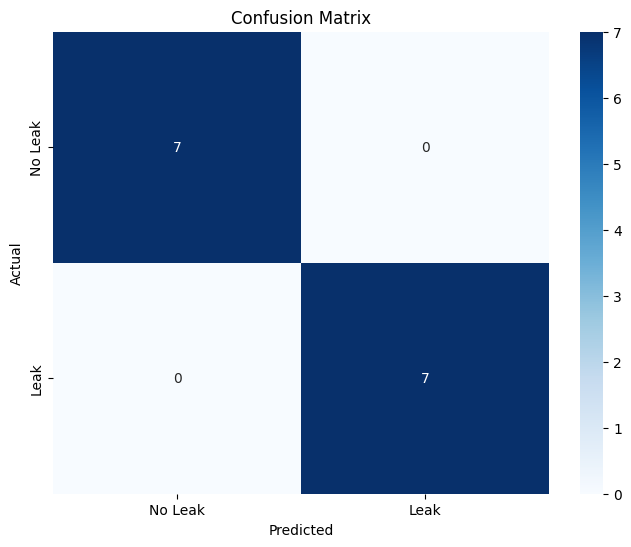

In [15]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Step 1: Train the SVM classifier
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Step 2: Make predictions
y_pred = svm_classifier.predict(X_test)

# Step 3: Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Step 4: Display relevant plots
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Leak', 'Leak'], yticklabels=['No Leak', 'Leak'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot decision boundary (only if X has 2 features for visualization purposes)
if X_train.shape[1] == 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', s=20, edgecolors='k')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', s=100, alpha=0.5, edgecolors='k')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap='coolwarm', alpha=0.5)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

In [ ]:
import serial
import numpy as np
import time
import pandas as pd

# Configuration des paramètres
SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200
NUM_SAMPLES = 1024
DURATION = 10  # Durée d'enregistrement

ser = serial.Serial(SERIAL_PORT, BAUD_RATE)
print(f"Starting real-time classification for {DURATION} seconds...")

start_time = time.time()
try:
    while time.time() - start_time < DURATION:
        if ser.in_waiting:
            try:
                data = ser.readline().decode().strip()
                fft_data = [float(x) for x in data.split(",") if x]
                if len(fft_data) == NUM_SAMPLES // 2:
                    # Preprocess the data
                    fft_data = pd.DataFrame([fft_data], columns=X.columns)
                    fft_data = scaler.transform(fft_data)
                    
                    # Make prediction
                    prediction = svm_classifier.predict(fft_data)
                    print(f"Prediction: {'Leak' if prediction[0] == 1 else 'No Leak'}")
                else:
                    print(f"Unexpected FFT data length: {len(fft_data)}")
            except Exception as e:
                print(f"Error reading data: {e}")
finally:
    ser.close()
    print("Real-time classification ended.")

Starting real-time classification for 10 seconds...
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
Prediction: No Leak
